In [1]:
import numpy as np
from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# from sklearn import cross_validation, metrics
from sklearn import metrics
from sklearn import linear_model
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import statsmodels.api as sm
import statsmodels.regression.linear_model
from statsmodels.tools.tools import add_constant
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
%matplotlib inline

In [2]:
X = np.load('var.npy')
y = np.load('count.npy')
X[np.isnan(X)] = 0
# X = add_constant(X)

In [18]:
# preprocessing ZCA code from https://stackoverflow.com/questions/6574782/how-to-whiten-matrix-in-pca
def whiten(X,fudge=1E-18):

   # the matrix X should be observations-by-components

   # get the covariance matrix
    Xcov = np.dot(X.T,X)

   # eigenvalue decomposition of the covariance matrix
    d, V = np.linalg.eigh(Xcov)

   # a fudge factor can be used so that eigenvectors associated with
   # small eigenvalues do not get overamplified.
    D = np.diag(1. / np.sqrt(d+fudge))

   # whitening matrix
    W = np.dot(np.dot(V, D), V.T)

   # multiply by the whitening matrix
    X_white = np.dot(X, W)

    return X_white

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

In [19]:
%%time
X_train = whiten(X_train)

CPU times: user 3.11 ms, sys: 1.13 ms, total: 4.25 ms
Wall time: 1.83 ms


In [20]:
X_train.shape

(3872, 35)

In [41]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
rf = rfc(n_estimators=10, oob_score=False, random_state=10, n_jobs=4, min_samples_leaf=1, min_samples_split=2)
rf.fit(X_train,y_train)
# print(rf.score)
# print (rf.oob_score_)
# y_pred = rf0.predict(X_test)

# plt.figure(figsize=(6,6))
# im = plt.imshow(confusion_matrix(y_test, y_pred), interpolation='none')
# plt.show()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [22]:
rf.score(X_train,y_train)

0.9865702479338843

In [23]:
rf.score(X_test,y_test)

0.2897432219193803

In [25]:
importances = rf.feature_importances_
importances

array([0.02601162, 0.03158607, 0.02711408, 0.02999613, 0.0277779 ,
       0.02571044, 0.02870678, 0.02854153, 0.02379963, 0.02789523,
       0.02796754, 0.02653658, 0.02888962, 0.02853972, 0.02547488,
       0.02780779, 0.0254923 , 0.02607316, 0.02624248, 0.02562522,
       0.02641579, 0.02675937, 0.02705733, 0.02504567, 0.02783888,
       0.02674327, 0.0312919 , 0.0289197 , 0.02960346, 0.02586995,
       0.02863672, 0.0276047 , 0.02744427, 0.03847009, 0.05651024])

In [29]:
features = ['wall', 'building', 'tree', 'road', 'sidewalk',
       'car', 'fence', 'railing', 'signboard', 'sky', 'person', 'skyscraper',
       'van', 'awning', 'streetlight', 'ashcan', 'ceiling', 'chair', 'bicycle',
       'grass', 'earth', 'bridge', 'minibike', 'plant', 'water', 'column',
       'sculpture', 'mountain', 'booth', 'windowpane', 'pier',
       'bulletin board', 'fountain', 'bike lane', 'route length']

In [34]:
indices

array([34, 33,  1, 26,  3, 28, 27, 12,  6, 30,  7, 13, 10,  9, 24, 15,  4,
       31, 32,  2, 22, 21, 25, 11, 20, 18, 17,  0, 29,  5, 19, 16, 14, 23,
        8])

Feature ranking:
1. feature 34: wall (0.056510)
2. feature 33: building (0.038470)
3. feature 1: tree (0.031586)
4. feature 26: road (0.031292)
5. feature 3: sidewalk (0.029996)
6. feature 28: car (0.029603)
7. feature 27: fence (0.028920)
8. feature 12: railing (0.028890)
9. feature 6: signboard (0.028707)
10. feature 30: sky (0.028637)
11. feature 7: person (0.028542)
12. feature 13: skyscraper (0.028540)
13. feature 10: van (0.027968)
14. feature 9: awning (0.027895)
15. feature 24: streetlight (0.027839)
16. feature 15: ashcan (0.027808)
17. feature 4: ceiling (0.027778)
18. feature 31: chair (0.027605)
19. feature 32: bicycle (0.027444)
20. feature 2: grass (0.027114)
21. feature 22: earth (0.027057)
22. feature 21: bridge (0.026759)
23. feature 25: minibike (0.026743)
24. feature 11: plant (0.026537)
25. feature 20: water (0.026416)
26. feature 18: column (0.026242)
27. feature 17: sculpture (0.026073)
28. feature 0: mountain (0.026012)
29. feature 29: booth (0.025870)
30. featur

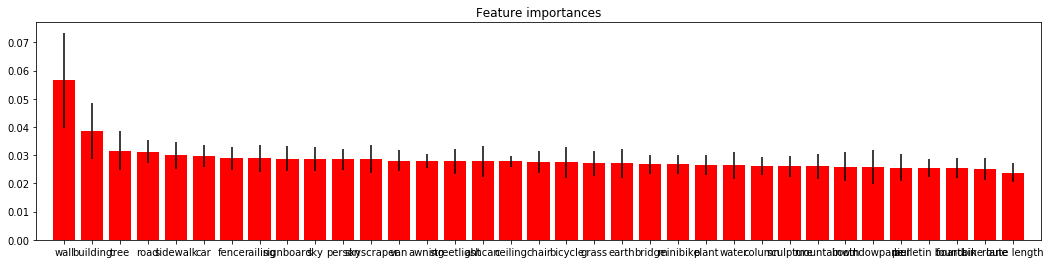

In [37]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_test.shape[1]):
    print("%d. feature %d: %s (%f)" % (f + 1, indices[f], features[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(18,4))
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_test.shape[1]), features)
plt.xlim([-1, X_test.shape[1]])

plt.show()

In [ ]:
from sklearn import tree

estimator = rf.estimators_[6]

# tree.export_graphviz(rf,out_file='tree.dot')
tree.export_graphviz(estimator, out_file='tree.dot')#, 
#                 feature_names = features,
# #                 class_names = i,
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')